# CitiBike
## Statement
Normally, dressing code would affect the choice of biker riders for commute. 

### Null Hypothesis
Male rider's trip duration is not significantly longer than or is equal to the trip duration of female riders. 

### Alternative Hypothesis
Male rider's trip duration is longer or than the trip duration of female riders. 

# _$H_0$_ : $T_{\mathrm{Man}}<= T_{\mathrm{Woman}}$
# _$H_1$_ : $T_{\mathrm{Man}} > T_{\mathrm{Woman}}$

or identically:

# _$H_0$_ : $T_{\mathrm{Man}} - T_{\mathrm{Woman}} <= 0 $
# _$H_1$_ : $T_{\mathrm{Man}} - T_{\mathrm{Woman}} > 0$
## The significance level chosen is  $\alpha=0.05$

In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import numpy as np
from scipy import stats
%pylab inline

if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2018")

Populating the interactive namespace from numpy and matplotlib
Must set env variable PUI2018


In [2]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")


In [3]:
datestring = '201601'
getCitiBikeCSV(datestring)

file in place, you can continue


In [4]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

tripduration          starttime           stoptime  start station id  \
0           923  1/1/2016 00:00:41  1/1/2016 00:16:04               268   
1           379  1/1/2016 00:00:45  1/1/2016 00:07:04               476   
2           589  1/1/2016 00:00:48  1/1/2016 00:10:37               489   
3           889  1/1/2016 00:01:06  1/1/2016 00:15:56               268   
4          1480  1/1/2016 00:01:12  1/1/2016 00:25:52              2006   

       start station name  start station latitude  start station longitude  \
0   Howard St & Centre St               40.719105               -73.999733   
1         E 31 St & 3 Ave               40.743943               -73.979661   
2        10 Ave & W 28 St               40.750664               -74.001768   
3   Howard St & Centre St               40.719105               -73.999733   
4  Central Park S & 6 Ave               40.765909               -73.976342   

   end station id            end station name  end station latitude  \
0            3002  South End Ave & Liberty St             40.711512   
1             498          Broadway & W 32 St             40.748549   
2             284       Greenwich Ave & 8 Ave             40.739017   
3            3002  South End Ave & Liberty St             40.711512   
4            2006      Central Park S & 6 Ave             40.765909   

   end station longitude  bikeid    usertype  birth year  gender  \
0             -74.015756   22285  Subscriber      1958.0       1   
1             -73.988084   17827  Subscriber      1969.0       1   
2             -74.002638   21997  Subscriber      1982.0       2   
3             -74.015756   22794  Subscriber      1961.0       2   
4             -73.976342   14562  Subscriber      1952.0       1   

                 date  
0 2016-01-01 00:00:41  
1 2016-01-01 00:00:45  
2 2016-01-01 00:00:48  
3 2016-01-01 00:01:06  
4 2016-01-01 00:01:12

In [23]:
len(df)

509478

In [5]:
df_2c =df[['tripduration','gender', 'date']]
df_2c.head()

tripduration  gender                date
0           923       1 2016-01-01 00:00:41
1           379       1 2016-01-01 00:00:45
2           589       2 2016-01-01 00:00:48
3           889       2 2016-01-01 00:01:06
4          1480       1 2016-01-01 00:01:12

In [29]:
#x = df['tripduration'].groupby(df['gender']).unique()
x = df['tripduration'][df['gender'] == 1].groupby(df['tripduration']).unique()
y = x.sort_values()
y1 = x.count()
y1

4243

In [7]:
# male vs. Female Ridership based on trip duration. For the Null Hypthsis female duration is higher than male or equal to male trip 

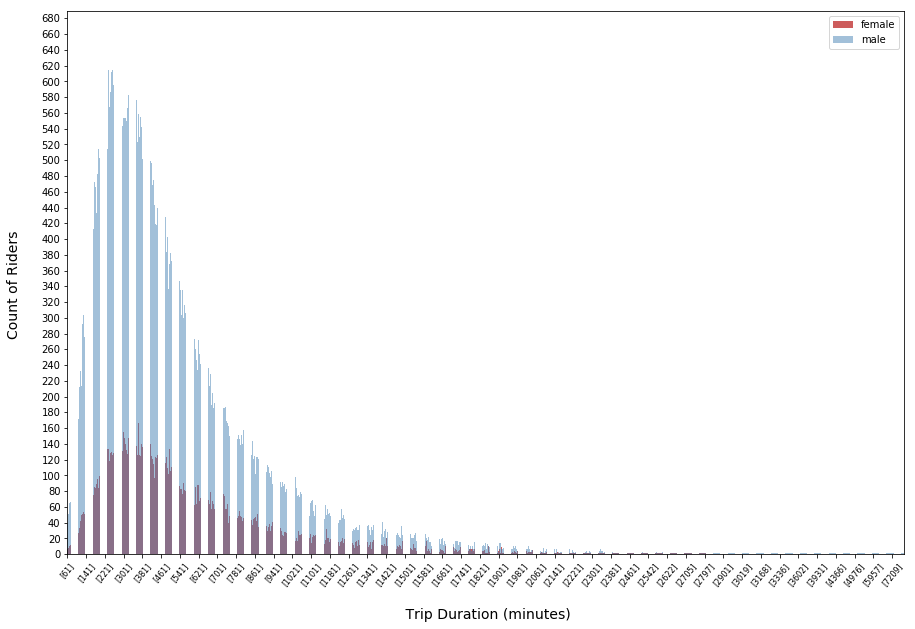

In [8]:
fig = pl.figure(figsize(15,10))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_w = 1
((df['tripduration'][df['gender'] == 2].groupby(df['tripduration']).count())).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='female')

norm_m = 1
ax = ((df['tripduration'][df['gender'] == 1].groupby(df['tripduration']).count())).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.5,
                                                                                              label='male')

#for i in range(y1):
 #   tmp = ax.xaxis.set_ticklabels(y[:i], fontsize=8, color='black', rotation = 70)
tmp = ax.xaxis.set_ticklabels(y[0::80], fontsize=8, color='black', rotation = 50)
ax.locator_params(nbins=45)
ax.set_ylabel('Count of Riders \n', fontsize = 14)
ax.set_xlabel('\n Trip Duration (minutes)', fontsize = 14)

pl.legend()

### Figure1.
The plot indicates Male rides' trip duration is not significantly longer or equal to female trip duration.



In [32]:
male_p = df['tripduration'][df['gender'] == 1].groupby(df['tripduration']).count()
female_p = df['tripduration'][df['gender'] == 2].groupby(df['tripduration']).count()

In [22]:
print(std(male_p), std(female_p))

156.82688466831112 42.642380663210076


In [39]:
np.random.seed(333)

In [40]:
# Extracting samples from each subdata set
male_s = np.random.choice(male_p, 6000)
female_s = np.random.choice(female_p, 6000)

In [41]:
mean_m = male_s.mean()
mean_f = female_s.mean()
std_m = male_s.std()
std_f = female_s.std()
print('Male Mean:', mean_m, 'Male Std:', std_m, '\nFemale Mean:', mean_f, 'Female Std:', std_f)

Male Mean: 92.88533333333334 Male Std: 160.6471750500318 
Female Mean: 32.02883333333333 Female Std: 42.873527208588236


In [42]:
# Student's T calculation:
std_2 = (0.5*(std_m**2+std_f**2))**0.5
t_score = (mean_m - mean_f)/(std_2*((2/6000)**0.5))
print('T-test result:',t_score)

T-test result: 28.351050855975828


In [43]:
import scipy.stats
scipy.stats.ttest_ind(male_s, female_s, equal_var=False)

Ttest_indResult(statistic=28.348688169955146, pvalue=2.9143530199552303e-167)

#### Interpretation:
The calculation of Student's Test shows that the p value is way smaller than 0.05 which is the selected significance level. Therefore, we can reject the null hypothesis. Instead, the alternative hypothesis is valid in this case.

In 2016 January, the average trip duration of male riders is higher than the average trip duration of female riders.